In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt

from src.lif import lif_compute, spike_binary
from src.ou_process import ouprocess_gaussian

In [39]:
TRIAL_NUM = 1000 # 100
tau_V = 10
R = 1 # MOhm
EL = -70.0
V_th = -40.0
dt = 0.1 # msec
t_stop = 1.0e3 # 50.0e3
tt = np.arange(0.0, t_stop, dt)
# p.dt = dt; p.tStop = t_stop; ????????
tw = 100.0

In [51]:
V = np.zeros((tt.shape[0], TRIAL_NUM)) # Membrane potential per neuron

# Additive noise to individual neurons
ETA, _ = ouprocess_gaussian(5.0, dt, t_stop, TRIAL_NUM)

In [52]:
# Slow Signal
input_slow, _ = ouprocess_gaussian(50.0, dt, t_stop, 1)
i_inj = 16.0 + 6.0*input_slow

F_binary = np.zeros((tt.shape[0], TRIAL_NUM))
avg_firing_rate = np.zeros(TRIAL_NUM)
a2 = 25.0 # pA; std of noise

I_total = a2*ETA + i_inj

for k in range(0, TRIAL_NUM):
#     I_total = i_inj.flatten() + a2*ETA[:,k]
    V[:,k] = lif_compute(I_total[:, k], R, tau_V, V_th, dt)

In [53]:
F_binary = spike_binary(V)
avg_firing_rate = np.sum(F_binary, axis=0)/(t_stop/1.0e3)

(array([  6.,  29., 163., 183., 327., 151., 102.,  24.,  12.,   3.]),
 array([ 8. , 10.5, 13. , 15.5, 18. , 20.5, 23. , 25.5, 28. , 30.5, 33. ]),
 <a list of 10 Patch objects>)

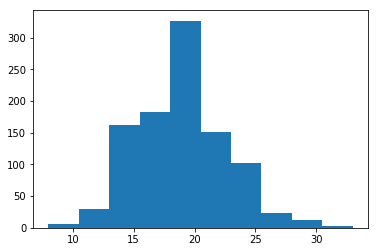

In [54]:
plt.hist(avg_firing_rate)

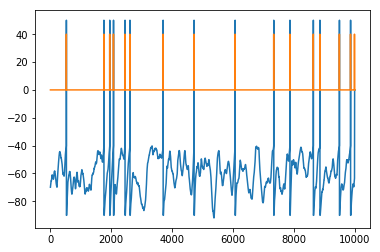

In [55]:
trial = 1
plt.plot(V[:,trial])
plt.plot(F_binary[:,trial] * 40.0)
plt.show()

In [12]:
k = 0
I_total = i_inj + a2*ETA[:,k]
V[:,k] = lif_compute(I_total, R, tau_V, V_th, dt)
V_selected = V[:, k, None]